# HW2

In [107]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize_scalar

## (a)
Let $g_1(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}$.
$$ 
\begin{align*}
Z &= \int_{-\infty}^{\infty} e^{-(x^4-2x^2+1)} dx \\
&= \int_{-\infty}^{\infty} \frac{e^{-(x^4-2x^2+1)}}{g_1(x)} g_1(x) dx \\ 
&= \int_{-\infty}^{\infty} \sqrt{2\pi} e^{-(x^4-2x^2+1 - x^2/2)} g_1(x) dx
\end{align*}
$$ 
We can calculate the last integral using a Gaussian random variable with pdf $g_1(x)$.

In [108]:
num_samples = 10**7
# loc = mean, scale = sigma
gauss_rv = np.random.normal(loc=0,scale=1,size=num_samples)

def func(x):
    '''
        The integrand whose expected value we will calculate using a Gaussian random variable
    '''
    return np.sqrt(2*np.pi)*np.exp(-x**4 + 2*x**2 - 1 + 0.5*x**2)

Z_rv = np.mean(func(gauss_rv))
print("Z calculated using Gaussian random variable:",Z_rv)

Z calculated using Gaussian random variable: 1.9735358616781318


I will now calculate Z using a numerical quadrature scheme
$$ \int_a^b f(x) dx \approx \frac{b-a}{2N} \left(f(x_0) + 2 f(x_1) + \ldots + 2 f(x_{n-1}) + f(x_n) \right) $$

In [109]:
def f_without_Z(x):
    '''
        Integrand in the integral for Z
    '''
    return np.exp(-x**4 + 2*x**2 - 1) 

a = 3
print("f({:d}) = ".format(a),f(a))
# so for a = 3, f(a) < 1e-16

# samples to use the trapezoidal rule
num_samples_int = 10**7
x_vec = np.linspace(-a,a,num_samples_int,endpoint=True)
dx = x_vec[1]-x_vec[0]
Z_int = 0.5*dx*np.sum(2*f_without_Z(x_vec) - f_without_Z(x_vec[0]) - f_without_Z(x_vec[-1])) 
print("Z calculated using trapezoidal rule",Z_int)

f(3) =  8.126586000747358e-29
Z calculated using trapezoidal rule 1.9737321496235927


In [110]:
print("Percentage error in Z calculated by two methods",np.abs(100*(Z_rv - Z_int)/Z_rv),"%")

Percentage error in Z calculated by two methods 0.009946003478953072 %


## (b)

Define $$h(x) = f(x)/g_\sigma(x) = \frac{\sqrt{2\pi\sigma^2}}{Z} e^{-(x^4-2x^2+1) + \frac{x^2}{2\sigma^2}}$$

Minimizing $h(x)$, we get, $-4 x^3 + 4 x + \frac{x}{\sigma^2} = 0 \implies x^2 = 1 + \frac{1}{4\sigma^2}$ or $x = 0$. Maxima occurs at $x=0$

Let $x_* = \sqrt{1 + \frac{1}{4\sigma^2}}$, I will plot $h(x_*(\sigma))$ as a function of $\sigma$.

Text(0,0.5,'$h_\\sigma(x_*)$')

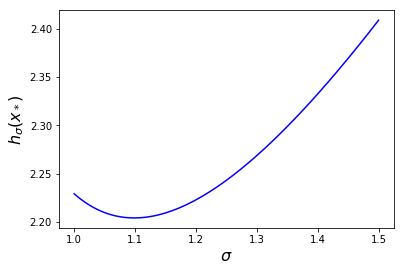

In [112]:
def f(x):
    # using the Z calculated using Gaussian samples
    return f_without_Z(x)/Z_rv

def h(x,sigma):
    return np.sqrt(2*np.pi*sigma**2) * f(x) * np.exp(x**2/(2*sigma**2))

def x_star(sigma):
    return np.sqrt(1 + 1/(4*sigma**2))

sigma_vec = np.linspace(1,1.5,100)
plt.plot(sigma_vec,h(x_star(sigma_vec),sigma_vec),color="b")
plt.xlabel(r"$\sigma$",fontsize=16)
plt.ylabel(r"$h_\sigma(x_*)$",fontsize=16)

### Minimizing $h(x_*(\sigma))$ as a function of $\sigma$
I will use the `minimize_scalar` function from `scipy.optimize`

In [113]:
from scipy.optimize import minimize_scalar
h_sigma = lambda x : h(x_star(x),x)
res = minimize_scalar(h_sigma,bounds=(1,1.5),method='bounded')
print(res)
print("Minimum occurs at sigma =",res.x,"and the value at minimum is",h_sigma(res.x))

     fun: 2.2041274803175854
 message: 'Solution found.'
    nfev: 10
  status: 0
 success: True
       x: 1.0986839332666285
Minimum occurs at sigma = 1.0986839332666285 and the value at minimum is 2.2041274803175854


## (c)
Sampling $f(x) = \frac{1}{Z} e^{-(x^4-2x^2+1)}$ using the acceptance-rejection method

In [114]:
# optimal sigma
sigma = res.x
# optimal value of h(x_*(\sigma)) 
c = h_sigma(sigma) 

# guassian samples with optimum sigma
# loc = mean, scale = sigma
num_samples = 10**7
gauss_rv_sigma = np.random.normal(loc=0,scale=sigma,size=num_samples)

def g_sigma(x):
    return (1.0/np.sqrt(2*np.pi*sigma**2)) * np.exp(-x**2/(2*sigma**2))

# ratio of f(x)/(c*g(x))
ratio = f(gauss_rv_sigma)/(c*g_sigma(gauss_rv_sigma))
uniform_samples = np.random.uniform(0,1,num_samples)
# set rejected ratios to -1 for identification later
ratio[np.where(uniform_samples > ratio)] = -1

acceptance_prob = len(np.where(ratio >= 0)[0])/num_samples
print("Acceptance prob.",acceptance_prob)
print("Expected acceptance prob. = 1/c =",1/c)

Acceptance prob. 0.4535892
Expected acceptance prob. = 1/c = 0.4536942662934874


**Historgram** for samples from $f(x)$

Text(0,0.5,'Prob.')

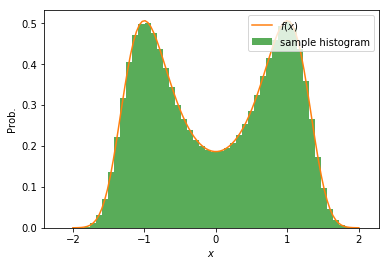

In [115]:
# accepted samples
f_x_samples = gauss_rv_sigma[np.where(ratio >= 0)]

plt.hist(f_x_samples,bins=50,density=True,facecolor="g",alpha=0.65,histtype="stepfilled",label="sample histogram")

# exact distribution
x_vec = np.linspace(-2,2,100)
f_x = f(x_vec)

plt.plot(x_vec,f_x,label=r"$f(x)$")
plt.legend(loc="upper right")
plt.xlabel(r"$x$")
plt.ylabel(r"Prob.")

## (d)
Finding $E[|x|]$

In [116]:
E_abs_x = np.mean(np.abs(f_x_samples))
print("E[|x|] =",E_abs_x)

E[|x|] = 0.8271746000772472
